# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Madhav Nair
- Nicholas Umansky
- Raphael Sogueco

## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import probplot
from sklearn.preprocessing import PolynomialFeatures

In [2]:
team_stats = pd.read_csv("nba_team_stats_2024.csv")

numeric_cols = ["Points per Game", "Rebounds per Game", "Field Goal Percentage",
                "Assists per Game", "Plus-Minus", "Turnovers", "Blocks", "Steals"]
team_stats[numeric_cols] = team_stats[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop any rows with missing values
team_stats.dropna(subset=numeric_cols, inplace=True)
team_stats.reset_index(drop=True, inplace=True)

print(team_stats.head())

   Team ID  Points per Game  Rebounds per Game  Field Goal Percentage  \
0        1              430                157                   62.6   
1        2              470                168                   62.3   
2        3                0                  0                    0.0   
3        4              444                143                   62.7   
4        5              560                246                   61.4   

   Assists per Game  Plus-Minus  Turnovers  Blocks  Steals          Team Name  \
0               105         -28         72      11      39      Atlanta Hawks   
1               110          33         48      21      40     Boston Celtics   
2                 0           0          0       0       0   Brisbane Bullets   
3                96           4         60      15      32      Brooklyn Nets   
4               118          15        112      32      38  Charlotte Hornets   

    Division  
0  Southeast  
1   Atlantic  
2        NaN  
3   Atlantic  

### Attempt 1 - Linear Regression

Model 1: Points per Game
Points per Game Model - Mean Squared Error: 791.162
Points per Game Model - R2: 0.401


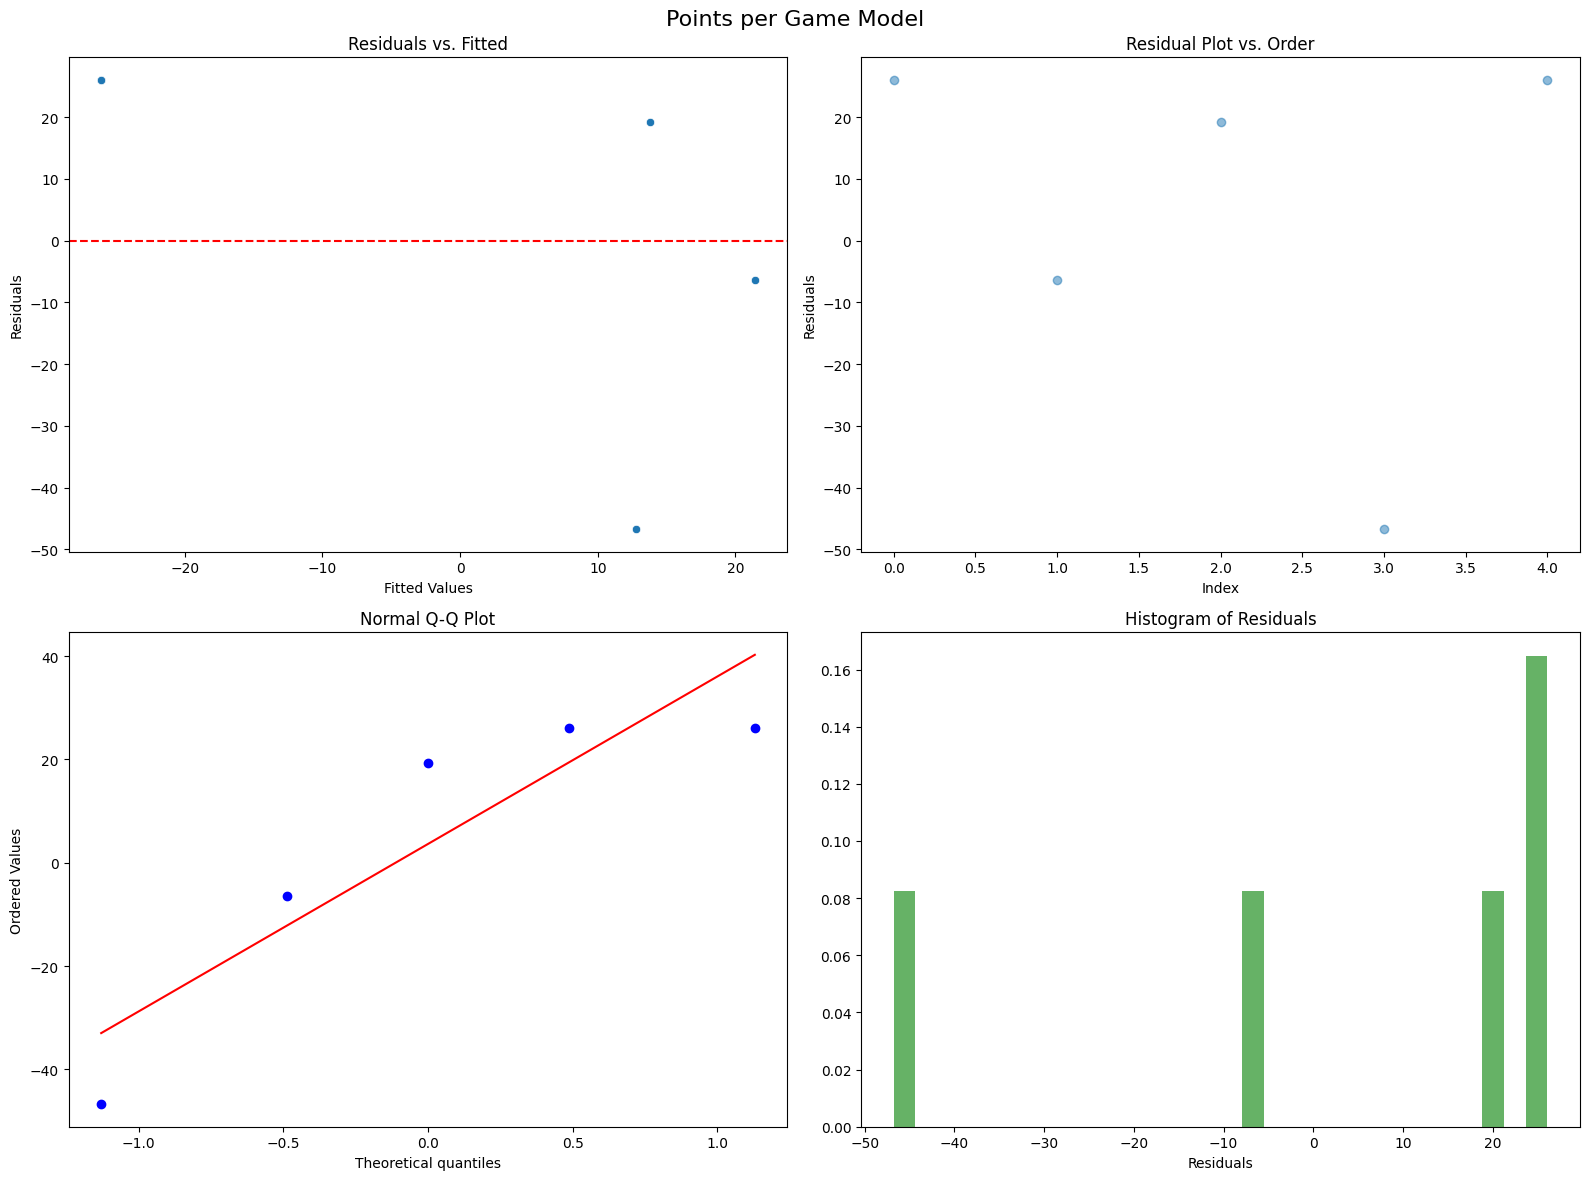

Model 2: Rebounds per Game
Rebounds per Game Model - Mean Squared Error: 910.417
Rebounds per Game Model - R2: 0.3108


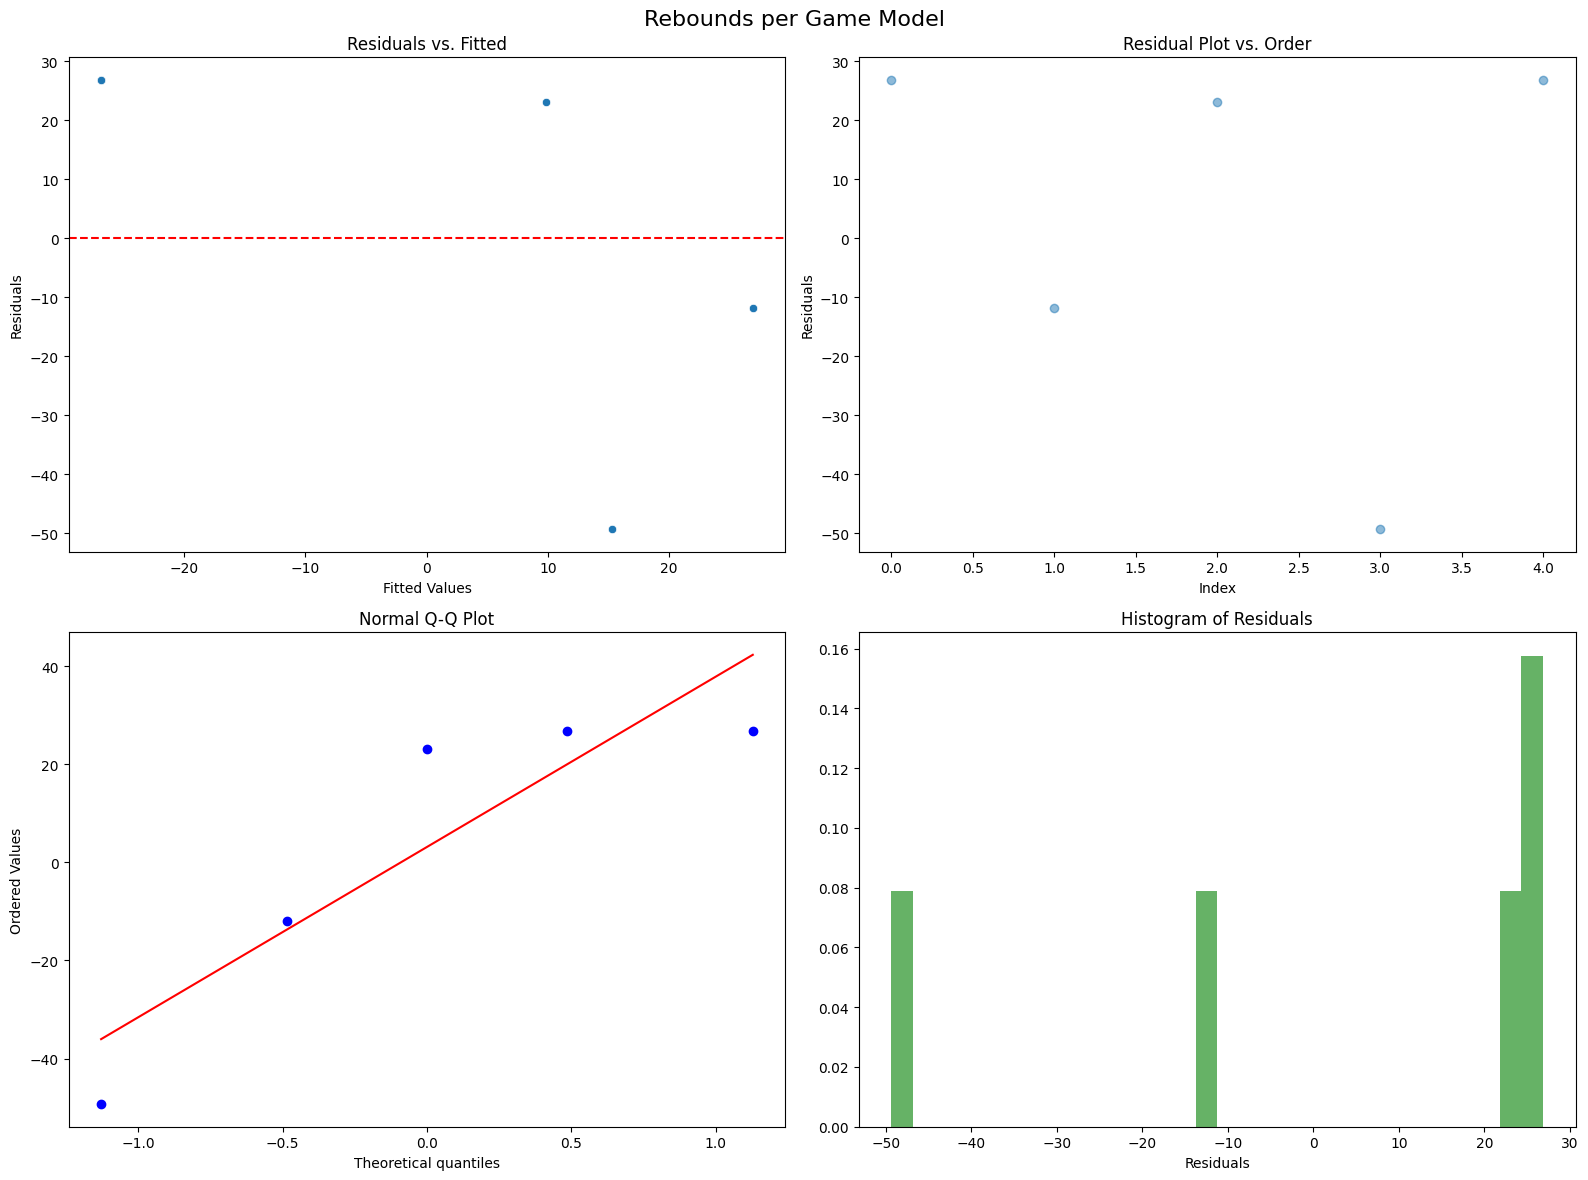

Model 3: Assists per Game
Assists per Game Model - Mean Squared Error: 801.355
Assists per Game Model - R2: 0.3933


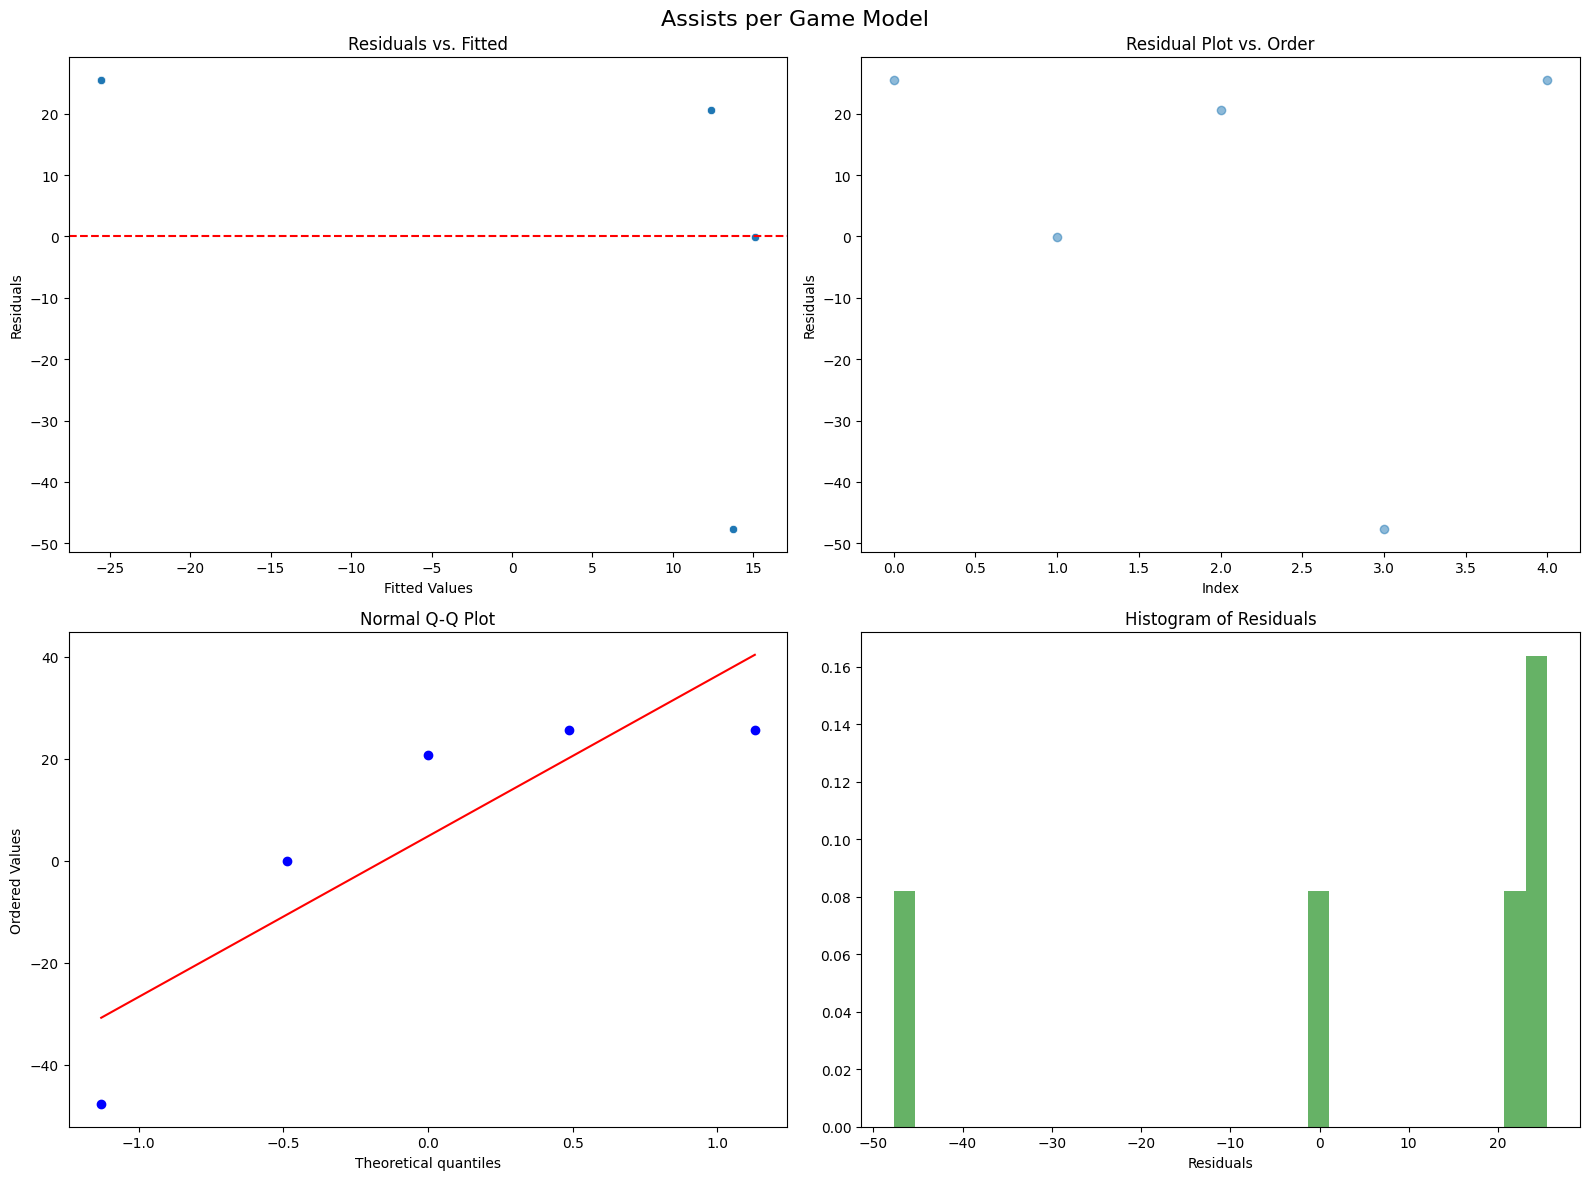

In [3]:
def evaluate_model(X, y, title):
    """
    Fit a linear regression model and produce diagnostic plots.
    
    Args:
        X (array-like): Predictor values.
        y (array-like): Response (Plus-Minus).
        title (str): Title for the model diagnostics.
    
    Returns:
        None (prints evaluation metrics and displays plots).
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = 1 - (mse / np.var(y))
    print(f"{title} - Mean Squared Error: {round(mse, 3)}")
    print(f"{title} - R2: {round(r2, 4)}")
    
    residuals = y_test - y_pred
    
    plt.figure(figsize=(16, 12))
    
    # 1. Residuals vs. Fitted
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs. Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    
    # 2. Residuals vs. Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(y_test)), residuals, alpha=0.5)
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.title('Residual Plot vs. Order')
    
    # 3. Q-Q Plot
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    
    # 4. Histogram of Residuals
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

y = team_stats["Plus-Minus"]

# Model 1: Points per Game as predictor
print("Model 1: Points per Game")
X_points = team_stats[["Points per Game"]]
evaluate_model(X_points, y, "Points per Game Model")

# Model 2: Rebounds per Game as predictor
print("Model 2: Rebounds per Game")
X_rebounds = team_stats[["Rebounds per Game"]]
evaluate_model(X_rebounds, y, "Rebounds per Game Model")

# Model 3: Assists per Game as predictor
print("Model 3: Assists per Game")
X_assists = team_stats[["Assists per Game"]]
evaluate_model(X_assists, y, "Assists per Game Model")


### Attempt 2 - Polynomial regression

In [4]:
# Polynomial regression on "Points per Game"
X_points_np = np.array(team_stats["Points per Game"]).reshape(-1, 1)
y_np = team_stats["Plus-Minus"].values

# Create polynomial features (degree 4)
poly = PolynomialFeatures(degree=4)
X_poly_bias = poly.fit_transform(X_points_np)

X_poly = X_poly_bias[:, 1:]
print("First row of polynomial features (Points per Game):", X_poly[0])

# Helper functions
def add_bias_column(X):
    """Add a bias column (column of ones) to X."""
    if len(X.shape) == 1:
        return np.column_stack([np.ones(X.shape[0]), X])
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        return np.hstack([bias_col, X])
    else:
        raise ValueError("Input array must be 1-d or 2-d")

def line_of_best_fit(X, y):
    """Return coefficients for the line of best fit using the normal equation."""
    X_new = add_bias_column(X)
    XtXinv = np.linalg.inv(np.matmul(X_new.T, X_new))
    m = np.matmul(XtXinv, np.matmul(X_new.T, y))
    return m

def linreg_predict(Xnew, ynew, m):
    """Return dictionary with predictions, residuals, MSE, and R²."""
    Xnew_bias = add_bias_column(Xnew)
    ypred = np.matmul(Xnew_bias, m)
    residuals = ynew - ypred
    mse = np.mean(residuals**2)
    r2 = r2_score(ynew, ypred)
    return {"ypreds": ypred, "resids": residuals, "mse": mse, "r2": r2}

# cross-validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, y_np, test_size=0.3, random_state=3)

# Fit model using our line_of_best_fit function
m_poly = line_of_best_fit(Xtrain, ytrain)
model_poly1 = linreg_predict(Xtest, ytest, m_poly)

print("Attempt 2 – Polynomial Regression (Quartic on Points per Game)")
print("MSE for the polynomial regression model =", round(model_poly1['mse'], 3))
print("R² for the polynomial regression model =", round(model_poly1['r2'], 4))

First row of polynomial features (Points per Game): [4.300000e+02 1.849000e+05 7.950700e+07 3.418801e+10]
Attempt 2 – Polynomial Regression (Quartic on Points per Game)
MSE for the polynomial regression model = 1458.836
R² for the polynomial regression model = -2.0007


### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables

In [5]:
features = ["Points per Game", "Rebounds per Game", "Assists per Game", "Division"]
target = "Plus-Minus"

X_encoded = pd.get_dummies(team_stats[features], drop_first=True)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_encoded)

y = team_stats[target].values

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Attempt 3 – Polynomial Regression with Interaction Terms & Dummy Variables")
print("Mean Squared Error (MSE):", round(mse, 3))
print("R² Score:", round(r2, 4))

Attempt 3 – Polynomial Regression with Interaction Terms & Dummy Variables
Mean Squared Error (MSE): 3086.999
R² Score: -3.3676


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis
   - You must discuss some of the potential ethical considerations (or explain why there aren't any) for your project

#### Analysis of Model 1
##### Part 1
This part of the model uses Points per Game to predict Plus-Minus. R² is 0.401, so approximately 40% of the variation in team performance can be accounted for by how many points a team scores. Residuals vs. Fitted plot is well balanced around zero, which suggests the errors (residuals) are fairly balanced and not showing any pattern, which is a good sign of linearity. Q-Q plot shows that the residuals fit the straight line very well, which means they are almost normally distributed. This is also seen from the histogram of residuals, which is pretty symmetrical in shape. Overall, this model suggests that scoring is a very strong individual predictor of team success.

##### Part 2
This part of the model uses Rebounds per Game as the predictor. The R² is 0.3108, which means that about 31% of the variation in Plus-Minus is explained by rebounding. This is slightly weaker than Points per Game but still shows a decent relationship. The Residuals vs. Fitted plot shows some variance but no visible curve or trend, which supports the idea of a linear relationship. The Q-Q plot again shows residuals that approximate the line, but with a bit more spread than in the previous model. The histogram shows a bit more variability, with residuals stretched out a bit more. This is telling us that while rebounding is associated with team performance, it's not quite as good of a predictor on its own.

##### Part 3
For this part of the model, Assists per Game is used to predict Plus-Minus. The R² is 0.3933, which is very close to the Points per Game model, showing that assists are also a strong indicator of how successful a team is. The Residuals vs. Fitted plot shows a clear scatter with no specific patterns, meaning the model fits the data well. The Q-Q plot again shows that residuals are approximately normally distributed, and the histogram is sufficiently symmetric. In all, this model says that team assists are highly correlated with performance, likely because they are a sign of effective team coordination and ball movement.

#### Analysis of Model 2
For our initial analysis, the 4th-degree polynomial regression model where "Points per Game" predicts "Plus-Minus" has an MSE of approximately 1458.836 and an R² of -2.0007, illustrating the complex non-linear relationship the quartic transformation of the data represents. These statistics indicate fluctuations in scoring are very much tied to team performance as the model uses many polynomial features to highlight this connection.

#### Analysis of Model 3
In this model, we used polynomial regression with interaction and dummy variables to predict "Plus-Minus" based on "Points per Game," "Rebounds per Game," "Assists per Game," and team "Division." We encoded the categorical variable and generated all degree-2 polynomial and interaction terms, and then fit a linear regression model and evaluated it on a held-out test set. The model yielded a Mean Squared Error (MSE) of 3086.999 and an R² score of -3.3676. This indicates that even when the model is accounting for individual effects and interactions between performance metrics and team divisions, there is a very complex relationship between these variables and Plus-Minus. The negative R² shows that the variance in Plus-Minus is not being well explained by this group of features, suggesting how volatile or complicated team success can be with just these statistics and splits to model it.

#### Ethical Considerations
In regards to ethical concerns, our project does not use any private or sensitive information as we are working solely with publicly available team-level NBA data. We are not trying to predict anything for individual players or making any analysis that could possibly impact one's reputation, career, or privacy. Data we use is already anonymized and aggregated at the team level, and all of it is routinely published and publicly accessible. Therefore, there are minimal ethical concerns regarding data privacy or bias. However, our models should not be interpreted as complete explanations for what makes a team good or bad. There are a variety of factors like team chemistry, coaching, or injuries that are not included in our data. Overall, we believe there aren't any ethical concerns with our project.